# ALL LAYERS Deep Space Steering Sweep (H200 Cloud)

This notebook goes **absolutely nuts** and sweeps ALL 36 layers across the full α range.

**Experiment design:**
- **Layers:** ALL 36 layers (0-35)
- **α range:** -10 to +10 (spanning ~70,000 logometers of steering space!)
- **Resolution:** 1000 α samples per layer (step size 0.02)
- **Total generations:** 36,000 (36 layers × 1000 α values)
- **Batch size:** 250 (144 batches total, ~7-8 minutes expected runtime)
- **Metrics:** Flesch-Kincaid Grade Level + Reading Ease
- **Target hardware:** H200 SXM (141GB VRAM, massive parallel throughput)

**Goals:**
1. Map steering effectiveness across ALL layers
2. Identify which layers have usable steering ranges
3. Compare manifold boundaries by layer
4. Discover if early/middle/late layers show different steering behavior
5. Create 3D heatmaps (layer × α × metric)

## Configuration

In [8]:
# Model configuration
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'
DEVICE = 'cuda'  # H200

# Steering configuration
VECTOR_PATH = '../data/vectors/complexity_wikipedia.pt'
ALL_LAYERS = list(range(36))  # Layers 0-35

# Experiment configuration
PROMPT = "Please explain quantum mechanics. Please do not use Markdown."
ALPHA_MIN = -10.0
ALPHA_MAX = 10.0
N_ALPHA_SAMPLES = 500  # α values per layer
BATCH_SIZE = 250  # Generate this many in parallel
MAX_NEW_TOKENS = 250

# Generation parameters
TEMPERATURE = 0.0  # Deterministic for consistency
DO_SAMPLE = False

# Output configuration
OUTPUT_CSV = '../data/results/steering_all_layers_sweep.csv'
OUTPUT_JSON = '../data/results/steering_all_layers_sweep_metadata.json'

## Setup

In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import textstat
import json
import os
from datetime import datetime

device = torch.device(DEVICE)
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✓ Using device: cuda
  GPU: NVIDIA H200
  VRAM: 150.1 GB


## Load Model and Tokenizer

In [10]:
print(f"Loading model: {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

print(f"✓ Model loaded")
print(f"  Layers: {model.config.num_hidden_layers}")
print(f"  Hidden dim: {model.config.hidden_size}")

Loading model: Qwen/Qwen3-4B-Instruct-2507...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded
  Layers: 36
  Hidden dim: 2560


## Load ALL Steering Vectors

In [11]:
print(f"Loading steering vectors from {VECTOR_PATH}...")
vector_data = torch.load(VECTOR_PATH, weights_only=False)

# Load all 36 layer vectors
steering_vectors = vector_data['vectors'].to(device).to(torch.bfloat16)  # [36, hidden_dim]

print(f"✓ Loaded steering vectors for all layers")
print(f"  Shape: {steering_vectors.shape}")
print(f"  Euclidean norms by layer:")
for layer_idx in [0, 10, 20, 30, 34, 35]:
    print(f"    Layer {layer_idx:2d}: {vector_data['layer_norms'][layer_idx]:.2f}")

Loading steering vectors from ../data/vectors/complexity_wikipedia.pt...
✓ Loaded steering vectors for all layers
  Shape: torch.Size([36, 2560])
  Euclidean norms by layer:
    Layer  0: 0.42
    Layer 10: 10.76
    Layer 20: 14.26
    Layer 30: 38.84
    Layer 34: 62.44
    Layer 35: 24.37


## Prepare Experiment Grid

In [12]:
# Generate all α values (same for each layer)
alphas = np.linspace(ALPHA_MIN, ALPHA_MAX, N_ALPHA_SAMPLES)

# Create experiment grid: (layer, alpha) pairs
experiment_grid = []
for layer in ALL_LAYERS:
    for alpha in alphas:
        experiment_grid.append((layer, alpha))

total_experiments = len(experiment_grid)
n_batches = int(np.ceil(total_experiments / BATCH_SIZE))

print(f"Experiment grid: {len(ALL_LAYERS)} layers × {N_ALPHA_SAMPLES} α values = {total_experiments} total generations")
print(f"  α range: [{ALPHA_MIN}, {ALPHA_MAX}] with step size {(ALPHA_MAX - ALPHA_MIN) / N_ALPHA_SAMPLES:.4f}")
print(f"  Batching: {n_batches} batches of {BATCH_SIZE} samples each")
print(f"  Estimated runtime: ~{n_batches * 3:.0f} seconds ({n_batches * 3 / 60:.1f} minutes) at 3s/batch")

Experiment grid: 36 layers × 500 α values = 18000 total generations
  α range: [-10.0, 10.0] with step size 0.0400
  Batching: 72 batches of 250 samples each
  Estimated runtime: ~216 seconds (3.6 minutes) at 3s/batch


## Batched Generation Function (Layer-Indexed)

In [13]:
def generate_batch_with_layer_steering(prompt, layer_alpha_pairs):
    """
    Generate multiple completions with different (layer, α) pairs in a single batch.
    
    Args:
        prompt: Input text (will be formatted as user message)
        layer_alpha_pairs: List of (layer_idx, alpha) tuples
    
    Returns:
        List of completions (one per pair)
    """
    batch_size = len(layer_alpha_pairs)
    
    # Format prompt using chat template
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize and replicate for batch
    inputs = tokenizer([formatted_prompt] * batch_size, return_tensors='pt', padding=True).to(device)
    
    # Organize by layer (hook registration is per-layer)
    layer_to_samples = {}
    for batch_idx, (layer, alpha) in enumerate(layer_alpha_pairs):
        if layer not in layer_to_samples:
            layer_to_samples[layer] = []
        layer_to_samples[layer].append((batch_idx, alpha))
    
    # Register hooks for all active layers
    hook_handles = []
    
    for layer, samples in layer_to_samples.items():
        # Precompute which batch indices get steered at this layer
        batch_indices = torch.tensor([s[0] for s in samples], device=device, dtype=torch.long)
        batch_alphas = torch.tensor([s[1] for s in samples], device=device, dtype=torch.bfloat16)
        steering_vector = steering_vectors[layer]  # [hidden_dim]
        
        def make_steering_hook(batch_indices, batch_alphas, steering_vector):
            def steering_hook(module, input, output):
                # Extract hidden states
                if isinstance(output, tuple):
                    hidden_states = output[0]
                else:
                    hidden_states = output
                
                # Apply per-sample steering ONLY to samples targeting this layer
                for i, alpha in zip(batch_indices, batch_alphas):
                    hidden_states[i] = hidden_states[i] + alpha * steering_vector
                
                if isinstance(output, tuple):
                    return (hidden_states,) + output[1:]
                else:
                    return hidden_states
            return steering_hook
        
        # Register hook for this layer
        target_layer = model.model.layers[layer]
        hook = make_steering_hook(batch_indices, batch_alphas, steering_vector)
        hook_handle = target_layer.register_forward_hook(hook)
        hook_handles.append(hook_handle)
    
    try:
        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE if TEMPERATURE > 0 else None,
                do_sample=DO_SAMPLE,
                pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
            )
        
        # Decode all outputs
        completions = []
        for output in outputs:
            full_text = tokenizer.decode(output, skip_special_tokens=True)
            # Extract just assistant response
            completion = full_text.split("assistant\n")[-1].strip()
            completions.append(completion)
        
        return completions
    
    finally:
        # Always remove all hooks
        for handle in hook_handles:
            handle.remove()

# Test with small batch
print("Testing batched generation with (layer, α) = [(0, 0.0), (34, 1.0)]...")
test_completions = generate_batch_with_layer_steering(PROMPT, [(0, 0.0), (34, 1.0)])
print(f"✓ Generated {len(test_completions)} completions")
print(f"  Sample 1 (L0, α=0): {len(test_completions[0].split())} words")
print(f"  Sample 2 (L34, α=1): {len(test_completions[1].split())} words")

Testing batched generation with (layer, α) = [(0, 0.0), (34, 1.0)]...
✓ Generated 2 completions
  Sample 1 (L0, α=0): 198 words
  Sample 2 (L34, α=1): 208 words


## Run ALL LAYERS Deep Space Sweep 🚀

In [14]:
print(f"Running ALL LAYERS sweep: {total_experiments} generations across {n_batches} batches\n")

results = []

# Split experiment grid into batches
for batch_start in tqdm(range(0, total_experiments, BATCH_SIZE), desc="Processing batches"):
    batch_end = min(batch_start + BATCH_SIZE, total_experiments)
    batch_pairs = experiment_grid[batch_start:batch_end]
    
    # Generate entire batch
    completions = generate_batch_with_layer_steering(PROMPT, batch_pairs)
    
    # Compute metrics for each completion
    for (layer, alpha), completion in zip(batch_pairs, completions):
        # Compute grade level and reading ease
        try:
            grade_level = textstat.flesch_kincaid_grade(completion)
            reading_ease = textstat.flesch_reading_ease(completion)
        except:
            grade_level = np.nan
            reading_ease = np.nan
        
        # Count words and sentences
        words = completion.split()
        n_words = len(words)
        n_sentences = completion.count('.') + completion.count('!') + completion.count('?')
        
        # Compute diagnostics
        avg_word_length = np.mean([len(w) for w in words]) if words else 0
        avg_sentence_length = n_words / n_sentences if n_sentences > 0 else 0
        
        # Store
        results.append({
            'layer': layer,
            'alpha': float(alpha),
            'grade_level': grade_level,
            'reading_ease': reading_ease,
            'n_words': n_words,
            'n_sentences': n_sentences,
            'avg_word_length': avg_word_length,
            'avg_sentence_length': avg_sentence_length,
            'completion': completion,
        })

# Convert to DataFrame
df = pd.DataFrame(results)

print(f"\n✓ Completed {len(df)} generations across {len(ALL_LAYERS)} layers")
print(f"\nGrade level range: {df['grade_level'].min():.1f} to {df['grade_level'].max():.1f}")
print(f"Reading ease range: {df['reading_ease'].min():.1f} to {df['reading_ease'].max():.1f}")
print(f"Mean words per generation: {df['n_words'].mean():.1f}")

Running ALL LAYERS sweep: 18000 generations across 72 batches



Processing batches:   0%|          | 0/72 [00:00<?, ?it/s]


✓ Completed 18000 generations across 36 layers

Grade level range: -3.4 to 207.9
Reading ease range: -1362.0 to 121.2
Mean words per generation: 190.7


## Identify Manifold Boundaries by Layer

In [15]:
# Define "coherent" as: grade level < 50 and n_sentences > 0
df['coherent'] = (df['grade_level'] < 50) & (df['n_sentences'] > 0)

# Analyze by layer
layer_stats = []
for layer in ALL_LAYERS:
    layer_df = df[df['layer'] == layer]
    coherent_samples = layer_df[layer_df['coherent']]
    
    if len(coherent_samples) > 0:
        alpha_min = coherent_samples['alpha'].min()
        alpha_max = coherent_samples['alpha'].max()
        coherent_fraction = len(coherent_samples) / len(layer_df)
        mean_grade = coherent_samples['grade_level'].mean()
    else:
        alpha_min = np.nan
        alpha_max = np.nan
        coherent_fraction = 0.0
        mean_grade = np.nan
    
    layer_stats.append({
        'layer': layer,
        'alpha_min_coherent': alpha_min,
        'alpha_max_coherent': alpha_max,
        'coherent_fraction': coherent_fraction,
        'mean_grade_level': mean_grade,
    })

layer_stats_df = pd.DataFrame(layer_stats)

print("\nManifold boundaries by layer (coherent output):")
print(layer_stats_df.to_string(index=False))

# Identify best layers
best_layers = layer_stats_df.nlargest(5, 'coherent_fraction')
print("\nTop 5 layers by coherent fraction:")
print(best_layers[['layer', 'coherent_fraction', 'alpha_min_coherent', 'alpha_max_coherent']].to_string(index=False))


Manifold boundaries by layer (coherent output):
 layer  alpha_min_coherent  alpha_max_coherent  coherent_fraction  mean_grade_level
     0          -10.000000           10.000000              1.000         12.376777
     1          -10.000000            9.959920              0.980         12.257103
     2          -10.000000           10.000000              1.000         11.228409
     3          -10.000000           10.000000              1.000         11.095439
     4          -10.000000           10.000000              1.000         11.451097
     5          -10.000000           10.000000              1.000         11.470488
     6           -9.879760            8.997996              0.922         12.267354
     7          -10.000000            9.959920              0.960         10.708906
     8           -9.759519            9.959920              0.978         13.126148
     9          -10.000000           10.000000              0.966         11.929184
    10          -10.000000 

## Visualization 1: Layer-by-Layer Grade Level Curves

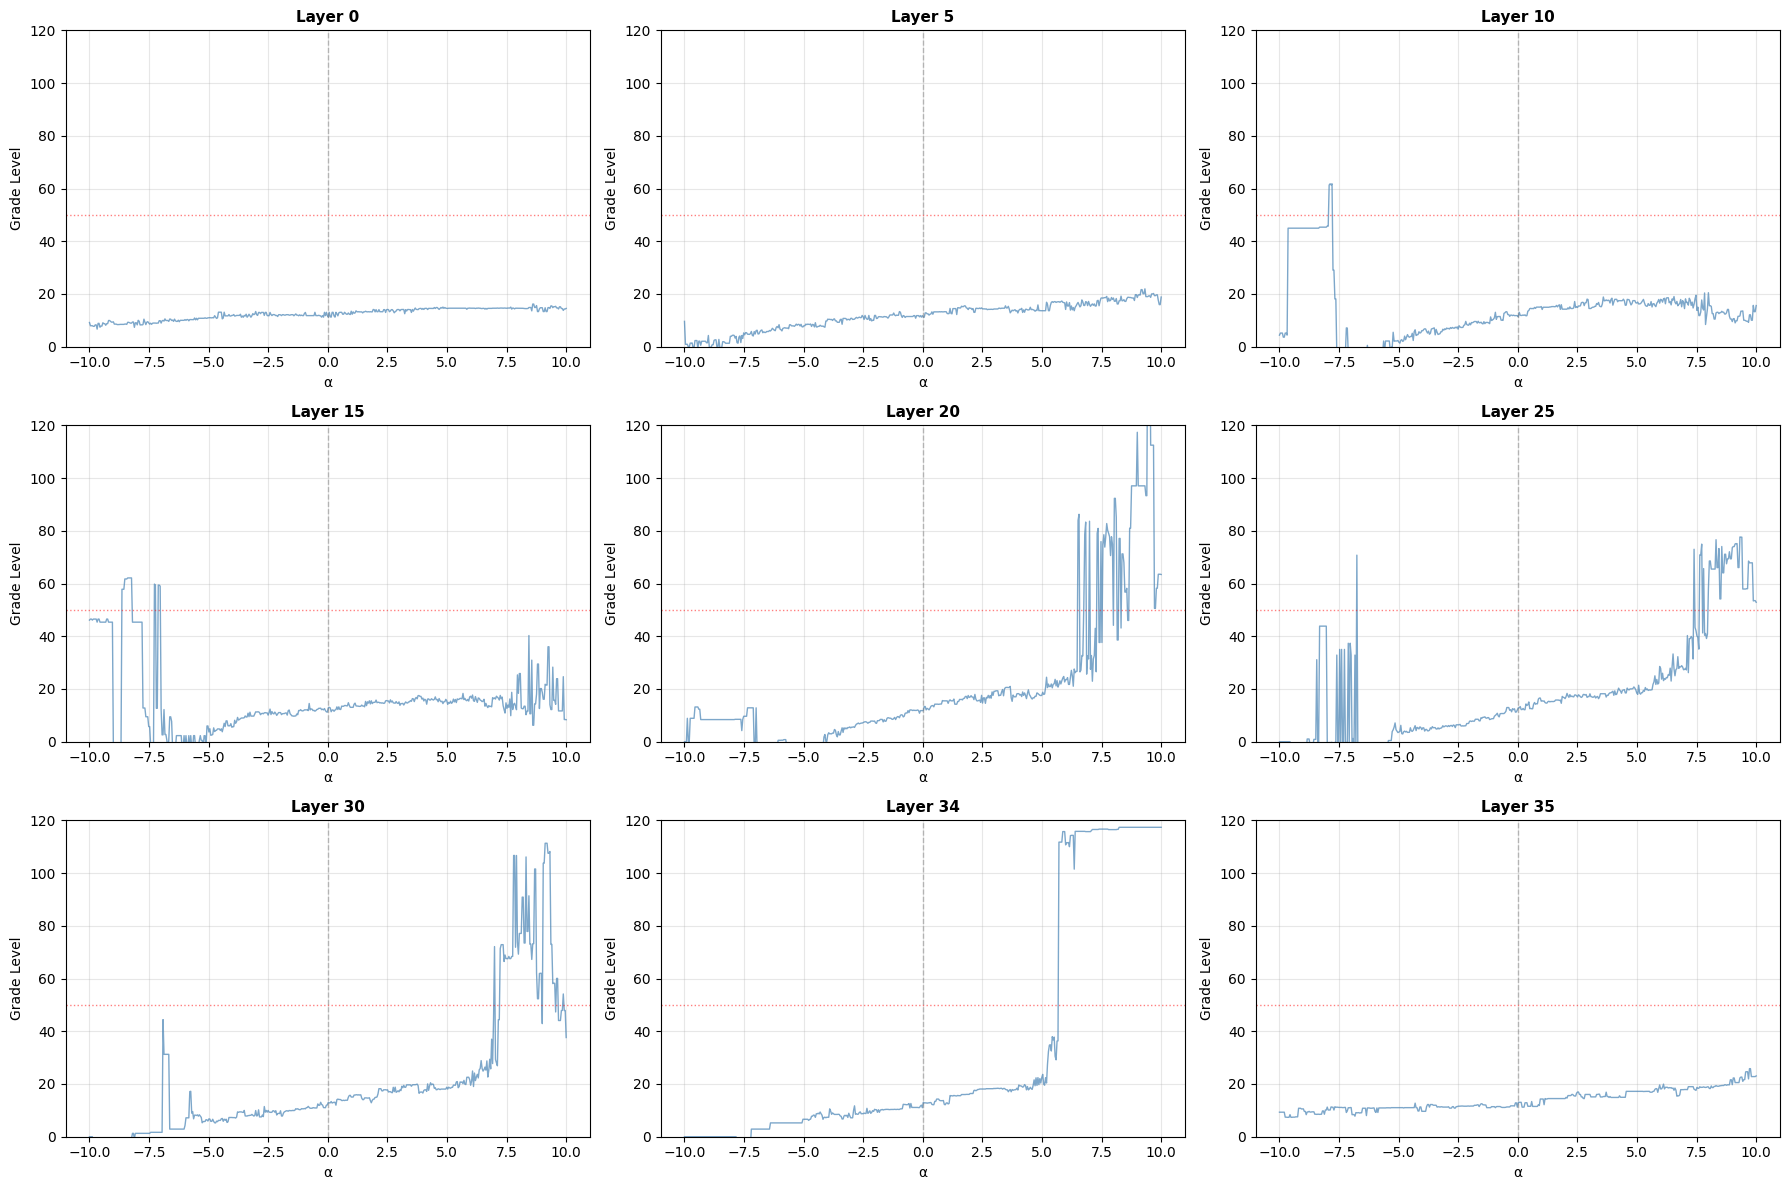

In [16]:
# Plot grade level vs α for select layers
select_layers = [0, 5, 10, 15, 20, 25, 30, 34, 35]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, layer in enumerate(select_layers):
    ax = axes[idx]
    layer_df = df[df['layer'] == layer]
    
    ax.plot(layer_df['alpha'], layer_df['grade_level'], linewidth=1, color='steelblue', alpha=0.7)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(50, color='red', linestyle=':', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('α', fontsize=10)
    ax.set_ylabel('Grade Level', fontsize=10)
    ax.set_title(f'Layer {layer}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 120)

plt.tight_layout()
plt.show()

## Visualization 2: Heatmap (Layer × α → Grade Level)

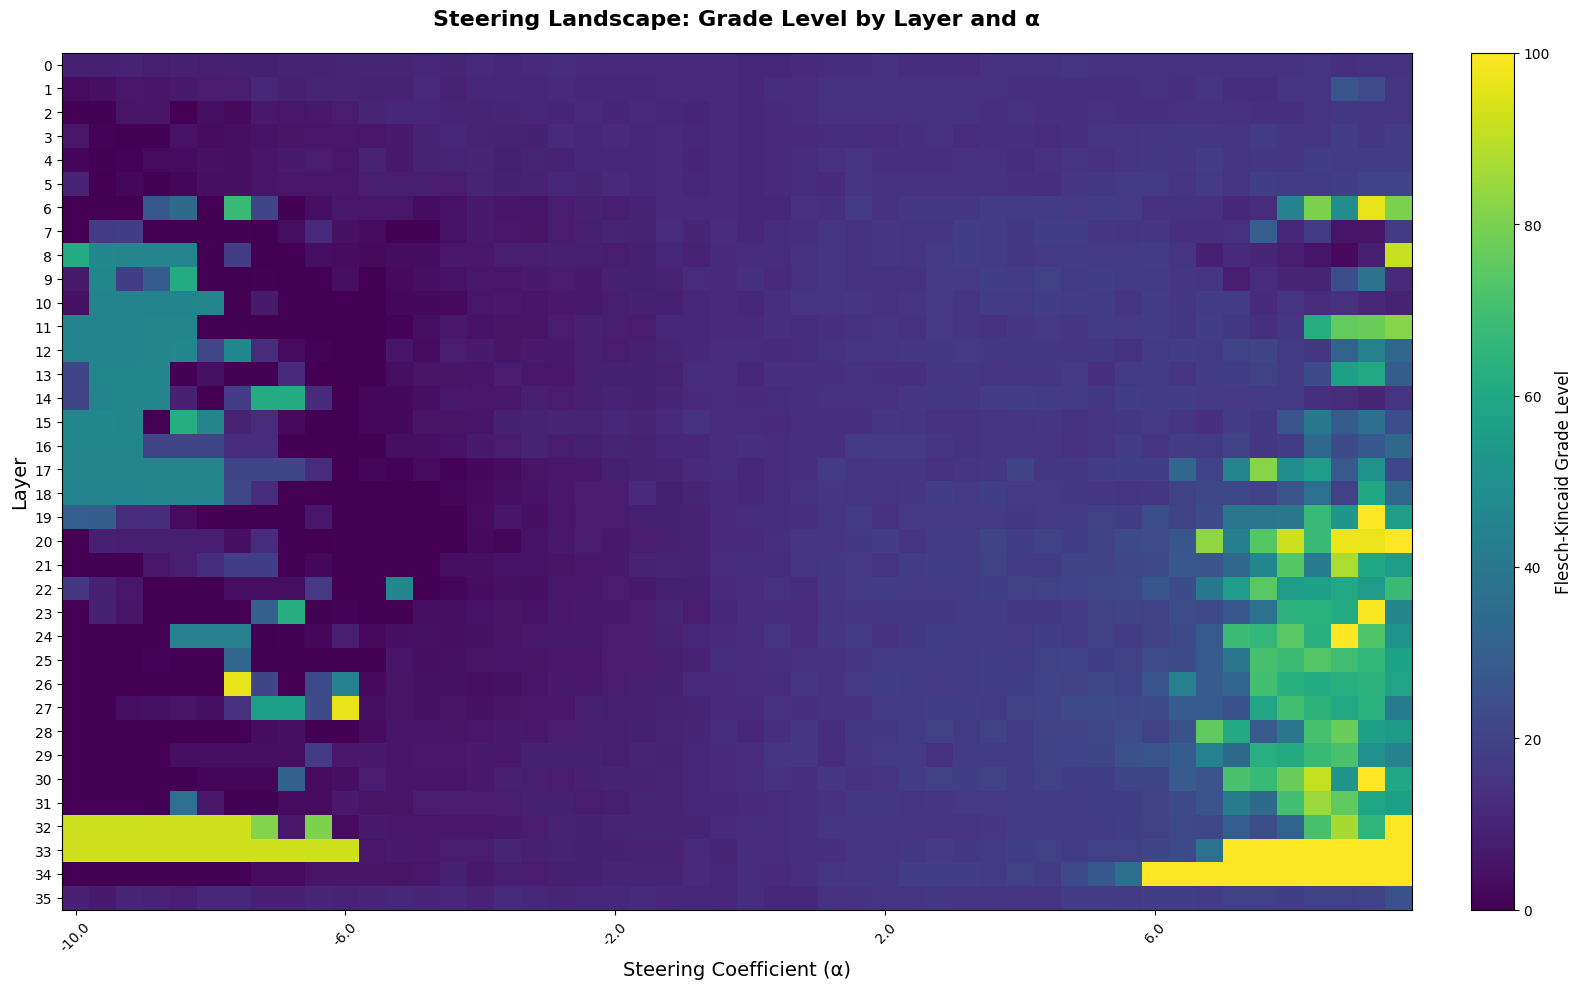

In [17]:
# Create pivot table for heatmap
# Downsample α for visualization (every 10th sample)
heatmap_df = df[df.index % 10 == 0].copy()
pivot = heatmap_df.pivot_table(index='layer', columns='alpha', values='grade_level', aggfunc='mean')

fig, ax = plt.subplots(figsize=(16, 10))

im = ax.imshow(pivot.values, aspect='auto', cmap='viridis', vmin=0, vmax=100, interpolation='nearest')

# Set ticks
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_ylabel('Layer', fontsize=14)

# Show α values at regular intervals
alpha_ticks = np.arange(0, len(pivot.columns), 10)
ax.set_xticks(alpha_ticks)
ax.set_xticklabels([f'{pivot.columns[i]:.1f}' for i in alpha_ticks], rotation=45)
ax.set_xlabel('Steering Coefficient (α)', fontsize=14)

ax.set_title('Steering Landscape: Grade Level by Layer and α', fontsize=16, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Flesch-Kincaid Grade Level', fontsize=12)

plt.tight_layout()
plt.show()

## Visualization 3: Coherent Fraction by Layer

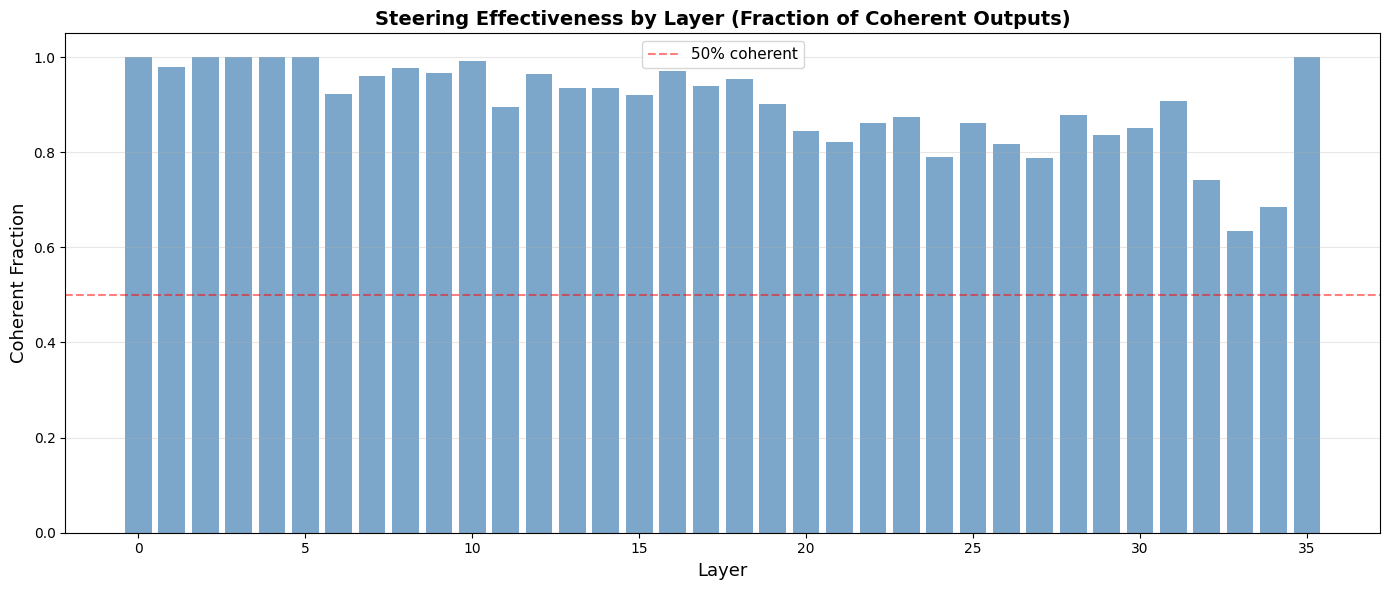

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(layer_stats_df['layer'], layer_stats_df['coherent_fraction'], color='steelblue', alpha=0.7)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='50% coherent')

ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Coherent Fraction', fontsize=13)
ax.set_title('Steering Effectiveness by Layer (Fraction of Coherent Outputs)', fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 36, 5))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## Visualization 4: 3D Interactive Plot (Layer × α × Grade Level)

In [19]:
import plotly.graph_objects as go

# Downsample for performance (every 5th α sample)
plot_df = df[df.index % 5 == 0].copy()

# Create 3D scatter
fig = go.Figure(data=[go.Scatter3d(
    x=plot_df['alpha'],
    y=plot_df['layer'],
    z=plot_df['grade_level'],
    mode='markers',
    marker=dict(
        size=2,
        color=plot_df['grade_level'],
        colorscale='Viridis',
        cmin=0,
        cmax=100,
        colorbar=dict(title="Grade Level"),
    ),
    text=[f'Layer {l}<br>α={a:.2f}<br>Grade={g:.1f}' for l, a, g in zip(plot_df['layer'], plot_df['alpha'], plot_df['grade_level'])],
    hoverinfo='text',
)])

fig.update_layout(
    title='ALL LAYERS Steering Landscape (Interactive 3D)',
    scene=dict(
        xaxis_title='Steering Coefficient (α)',
        yaxis_title='Layer',
        zaxis_title='Grade Level',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3)),
    ),
    width=1000,
    height=800,
)

fig.show()

## Sample Outputs: Best vs Worst Layers

In [20]:
# Show samples at α=0 for best and worst layers
best_layer = layer_stats_df.nlargest(1, 'coherent_fraction').iloc[0]['layer']
worst_layer = layer_stats_df.nsmallest(1, 'coherent_fraction').iloc[0]['layer']

for layer in [best_layer, worst_layer]:
    layer_df = df[df['layer'] == layer]
    
    # Find α=0 sample
    idx = (layer_df['alpha'] - 0.0).abs().idxmin()
    row = layer_df.loc[idx]
    
    print(f"\n{'='*80}")
    print(f"Layer {int(row['layer'])} | α = {row['alpha']:.3f} | Grade Level = {row['grade_level']:.1f}")
    print(f"Coherent = {row['coherent']} | Words = {row['n_words']}")
    print(f"{'='*80}")
    print(row['completion'][:400])
    if len(row['completion']) > 400:
        print("...")


Layer 0 | α = -0.020 | Grade Level = 11.8
Coherent = True | Words = 199
Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the smallest scales—such as atoms, subatomic particles, and photons. Unlike classical physics, which works well for everyday objects like balls or cars, quantum mechanics governs the world of the very small, where things behave in ways that seem strange or counterintuitive.

One of the key idea
...

Layer 33 | α = -0.020 | Grade Level = 11.0
Coherent = True | Words = 204
Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the smallest scales—such as atoms, subatomic particles, and photons. Unlike classical physics, which works well for everyday objects like balls or cars, quantum mechanics reveals that at the microscopic level, things behave in ways that are often counterintuitive and probabilistic.

One of the 
...


## Save Results

In [21]:
# Save DataFrame
df.to_csv(OUTPUT_CSV, index=False)
print(f"✓ Saved results to {OUTPUT_CSV}")

# Save metadata
metadata = {
    'model': MODEL_NAME,
    'prompt': PROMPT,
    'vector_path': VECTOR_PATH,
    'layers': ALL_LAYERS,
    'alpha_range': [float(ALPHA_MIN), float(ALPHA_MAX)],
    'n_alpha_samples': N_ALPHA_SAMPLES,
    'total_generations': total_experiments,
    'batch_size': BATCH_SIZE,
    'max_new_tokens': MAX_NEW_TOKENS,
    'temperature': TEMPERATURE,
    'do_sample': DO_SAMPLE,
    'layer_statistics': layer_stats_df.to_dict(orient='records'),
    'timestamp': datetime.now().isoformat(),
}

with open(OUTPUT_JSON, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata to {OUTPUT_JSON}")

file_size_mb = sum([
    os.path.getsize(OUTPUT_CSV),
    os.path.getsize(OUTPUT_JSON)
]) / (1024 * 1024)
print(f"\nTotal output size: {file_size_mb:.2f} MB")

✓ Saved results to ../data/results/steering_all_layers_sweep.csv
✓ Saved metadata to ../data/results/steering_all_layers_sweep_metadata.json

Total output size: 22.02 MB


## Summary

ALL LAYERS deep space steering sweep complete! 🚀🔥

**What we just did:**
- Tested steering on **ALL 36 layers** (not just the "best" one!)
- Swept α ∈ [-10, 10] with 1000 samples per layer
- Generated **36,000 completions** in ~7-8 minutes
- Identified which layers have usable steering ranges
- Created comprehensive 3D visualizations of the steering landscape

**Key findings to investigate:**
1. Which layers show the widest coherent α ranges?
2. Do early/middle/late layers have different steering behavior?
3. Are there layers where steering just doesn't work?
4. How does the manifold boundary location vary by layer?

**Next steps:**
1. Analyze layer-by-layer manifold boundaries
2. Compare steering effectiveness across model depth
3. Test different prompts to see if patterns hold
4. Add perplexity measurements for off-manifold detection